In [1]:
#!pip install glob2

In [2]:
# imports and globals
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
K = keras.backend

import tensorflow as tf

#gpus = tf.config.list_physical_devices('GPU')
#if gpus:
#    for gpu in gpus:
#        tf.config.experimental.set_memory_growth(gpu, True)

import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score



In [3]:
from PIL import Image
import numpy as np
import glob

def get_image(image_path):
    """Loads an image from the specified path."""
    return Image.open(image_path)

def image2array(image):
    """Converts a PIL image to a NumPy array."""
    return np.array(image)

def array2image(array):
    """Converts a NumPy array back to a PIL image."""
    return Image.fromarray(array)

def rescale(image, size=(128, 128), scale=1.0):
    """Rescales the image to the specified size and scale factor."""
    width, height = size
    width = int(width * scale)
    height = int(height * scale)
    return image.resize((width, height), Image.LANCZOS)  # Use Image.LANCZOS instead of Image.ANTIALIAS


# Full example for loading, resizing, and converting images
raw_data = []
raw_labels = []
label_val = 0
path = "e:/gan/flowers/sunflower"
file_type = "jpg"
image_size = (128, 128)  # Example size
image_scale = 1.0        # Example scale factor

for img_path in glob.glob(f"{path}/*.{file_type}"):
    #print(img_path)
    image = get_image(img_path)
    image = rescale(array2image(image2array(image)), image_size, image_scale)  # Perform rescale
    image_array = image2array(image)
    raw_data.append(image_array)
    raw_labels.append(label_val)

raw_data = np.asarray(raw_data)
raw_labels = np.asarray(raw_labels)
x_train, x_test, y_train, y_test = train_test_split(raw_data, raw_labels, test_size=0.2, random_state=42)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [4]:
def sampling(args):
    # Based on: https://keras.io/examples/generative/vae/
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.) 
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [5]:
def build_encoder(input_layer, latent_dimensions, kernel_size):
    x = Conv2D(64, kernel_size, activation='relu',padding='same',name='encoder-conv2d-64')(input_layer)
    x = MaxPooling2D((2, 2),name='encoder-maxpool1')(x)
    x = Conv2D(32, kernel_size, activation='relu',padding='same',name='encoder-conv2d-32')(x)
    x = MaxPooling2D((2, 2),name='encoder-maxpool2')(x)
    x = Conv2D(16, kernel_size, activation='relu',padding='same',name='encoder-conv2d-16')(x)
    x = MaxPooling2D((2, 2),name='encoder-maxpool3')(x)
    x = Conv2D(8, kernel_size, activation='relu',padding='same',name='encoder-conv2d-8')(x)
    encoder_shape = K.int_shape(x)[1:]
    x = Reshape((np.prod(encoder_shape),),name='encoder-reshape')(x)
    z_mean = Dense(latent_dimensions,activation='linear',name='encoder-z-mean')(x)
    z_log_var = Dense(latent_dimensions, name='encoder-z-log-var',activation='linear')(x)

    # reparameterization trick
    z = Lambda(sampling, output_shape=(latent_dimensions,), name='z')([z_mean, z_log_var])

    model = Model(input_layer, [z_mean, z_log_var, z], name='encoder')
    return model, z_mean, z_log_var, encoder_shape

In [6]:
def build_decoder(latent_dimensions, kernel_size, encoder_shape, input_shape):
    lats = Input(shape=(latent_dimensions,),name='latent')

    x = Dense(np.prod(encoder_shape),activation='relu',name='decoder-dense')(lats)
    x = Reshape(encoder_shape,name='decoder-reshape')(x)
    x = Conv2DTranspose(16, kernel_size, activation='relu',padding='same',name='decoder-conv2d-16')(x)
    x = UpSampling2D((2, 2),name='decoder-upsample1')(x)
    x = Conv2DTranspose(32, kernel_size, activation='relu',padding='same',name='decoder-conv2d-32')(x)
    x = UpSampling2D((2, 2),name='decoder-upsample2')(x)
    x = Conv2DTranspose(64, kernel_size, activation='relu',padding='same',name='decoder-conv2d-64')(x)
    x = UpSampling2D((2, 2),name='decoder-upsample3')(x)
    outputs = Conv2DTranspose(3, kernel_size, activation='relu',padding='same',name='decoder-output')(x)
    
    model = Model(lats, outputs, name='decoder')
    return model

In [7]:
def build_autoencoder(encoder, decoder, input_layer, z_mean, z_log_var, is_rgb):
    output_layer = decoder(encoder(input_layer)[2])
    vae = Model(input_layer, output_layer, name='autoencoder')

    reconstruction_axis = (1,2)
    if is_rgb: reconstruction_axis = (1,2,3)

    reconstruction_loss = tf.reduce_mean(1000.0*tf.square(input_layer-output_layer),axis=reconstruction_axis)
    
    kl_loss =  -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = 1)

    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.add_metric(tf.reduce_sum(1000.0*tf.square(input_layer-output_layer),axis=reconstruction_axis),name='reconstruction_loss',aggregation='mean')
    vae.add_metric(kl_loss,name='kl_loss',aggregation='mean')
    vae.compile(optimizer='adam')

    return vae, reconstruction_loss

In [8]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Lambda
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose

is_rgb = True  # or False, depending on your image format

import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks


model_name = "vae_sunflowers128"
TRAIN_IMAGE_DIMS = (128, 128, 3)
input_shape = TRAIN_IMAGE_DIMS
latent_dimensions = 200
batch_size = 8
epochs = 150
kernel_size = 3
input_layer = Input(shape=input_shape, name='encoder_input')

encoder, z_mean, z_log_var, encoder_shape = build_encoder(input_layer, latent_dimensions, kernel_size)
decoder = build_decoder(latent_dimensions, kernel_size, encoder_shape, input_shape)
autoencoder, reconstruction_loss = build_autoencoder(encoder, decoder, input_layer, z_mean, z_log_var, True)


callback_early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,#look at last x epochs
    min_delta=0.01,#loss must improve by this amount
    restore_best_weights=True,
)

#callback_checkpoint = callbacks.ModelCheckpoint("checkpoint_"+model_name+".h5", monitor='val_loss', 
#                             verbose=1, save_best_only=True,
#                             save_weights_only=False, mode='auto')

callback_checkpoint = callbacks.ModelCheckpoint(
    "checkpoint_" + model_name + ".h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_format="tf"  # Set the format to "tf" to avoid duplication issues
)
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[
                    callback_checkpoint,
                    callback_early_stopping
                ])
#autoencoder.save_weights(model_name + '.h5', save_format="tf")
autoencoder.save_weights(model_name, save_format="tf")


Epoch 1/150
103/103 [==============================] - ETA: 0s - loss: 96.8167 - reconstruction_loss: 4685753.0000 - kl_loss: 1.5628
Epoch 1: val_loss improved from inf to 85.07889, saving model to checkpoint_vae_sunflowers128.h5
103/103 [==============================] - 13s 98ms/step - loss: 96.8167 - reconstruction_loss: 4685753.0000 - kl_loss: 1.5628 - val_loss: 85.0789 - val_reconstruction_loss: 3968458.7500 - val_kl_loss: 4.2909
Epoch 2/150
103/103 [==============================] - ETA: 0s - loss: 75.2672 - reconstruction_loss: 3500880.2500 - kl_loss: 4.0800
Epoch 2: val_loss improved from 85.07889 to 73.20967, saving model to checkpoint_vae_sunflowers128.h5
103/103 [==============================] - 8s 82ms/step - loss: 75.2672 - reconstruction_loss: 3500880.2500 - kl_loss: 4.0800 - val_loss: 73.2097 - val_reconstruction_loss: 3320409.2500 - val_kl_loss: 5.6329
Epoch 3/150
103/103 [==============================] - ETA: 0s - loss: 70.6656 - reconstruction_loss: 3227144.5000 - k

1/1 [==============================] - 0s 23ms/step


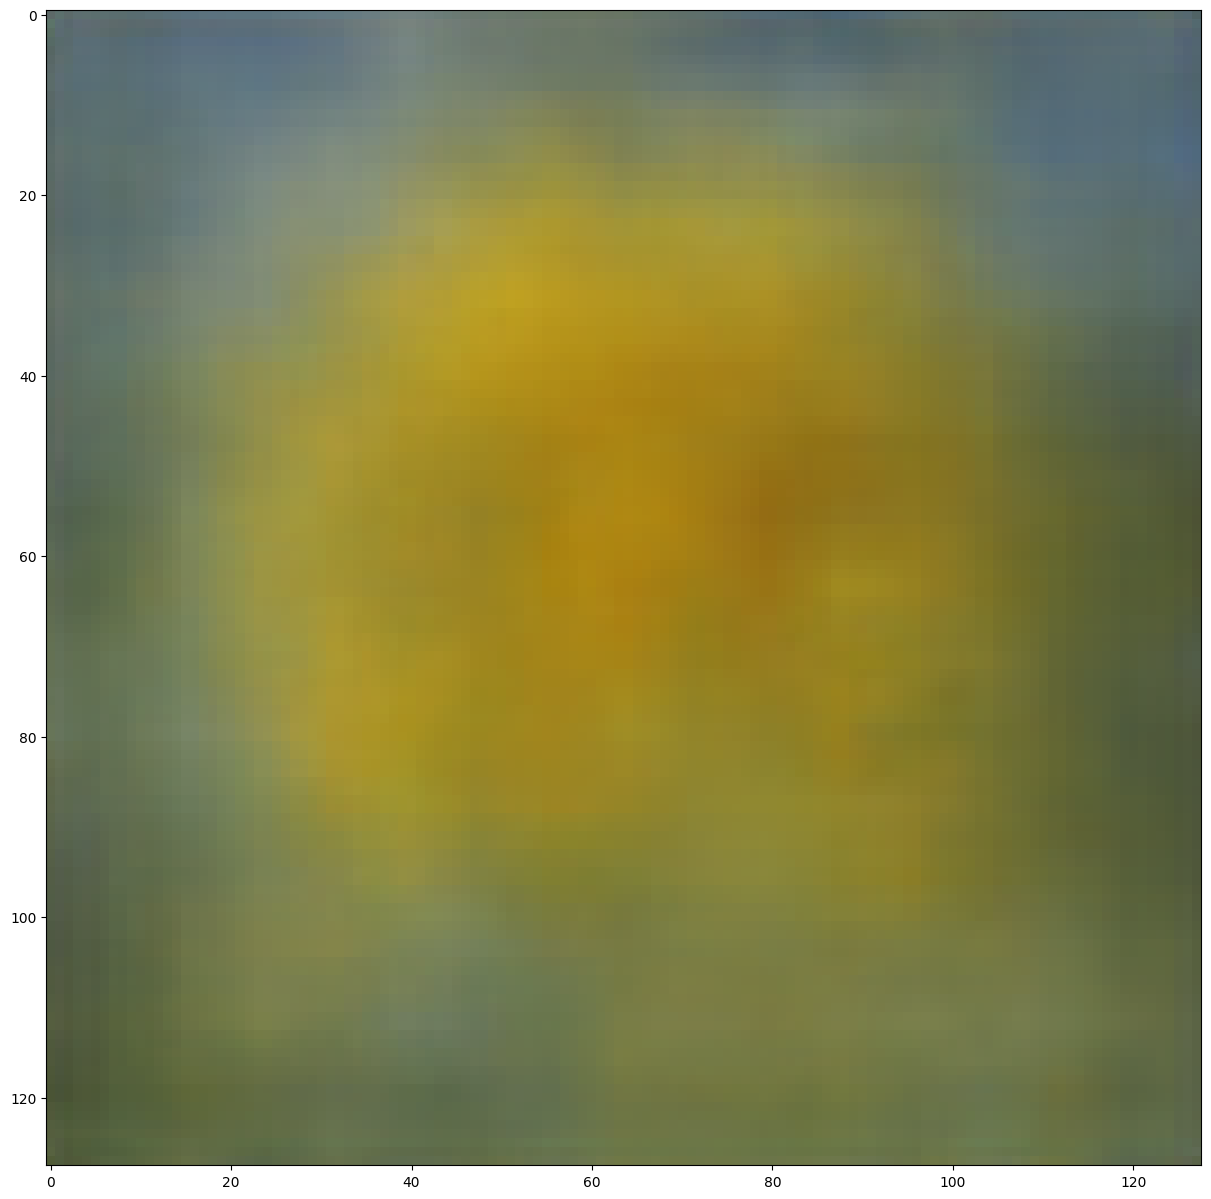

In [11]:
new_image = decoder.predict(np.random.normal(0,1,size=(1,latent_dimensions)))
plt.figure(figsize=(15, 15))
plt.imshow(new_image.squeeze())
plt.show()